# Gas Discharge & Stellar Feedback-driven Outflows (Part 2 / 2):
## Scaling, Fractional Heating, Accretion
`-- Leo Lonzarich, 31 October 2021 // [Updated 31-10-21] --`


### Table of Contents
- [Analysing Discharged Gas](#compare)
    - [Radial Position Scaling](#radialpositions)
    - [Radial Velocity Scaling](#velocities)
- [Fractional Heating](#fractional)
    - [Fraction SNe-Heated](#fractionsne)
    - [Fraction Ram Pressure-stripped](#fractionram)
- [Accretion of Discharged Gas](#accretion)
- [The Proving Grounds](#proving)


### General Comments on the Contents of this Noteboook
- Repeated pids that turn up in the data sets below (e.g. 'ejected,' 'expelled,' 'discharged') should mean that the same particle has been accreted and reejected more than once --- hence its reoccurance in the set.


- While each root data set is defined where used, definitions are included here for convenience:
    - *Ejected*: All gas partiles that have been removed from their respective satellite galaxy's disk and into the halo.
    - *Expelled*: All gas particles (either within the disk or halo of their respective satellite galaxy) that have been removed beyond the virial radius of their satellite; that is, all gas that has been completely removed from its respective satellite.
    - *Discharged*: All gas that has been removed from the disk of its respective satellite galaxy. This includes gas both moved to the halo and beyond the virial radius.
    - *predischarged*: This is essentially a data set containing the pre-properties of the discharged gas, that is, it contains all of those gas particles in the *discharged* set but with their properties before being discharged.
    - *dsrg_accreted*: **fill in**
    
    
- Units for key values used in this notebook:
    - *Time* is in Gigayears $(Gyrs)$.
    - *Distances* in kiloparsecs $(kpc)$.
    - *Velocities* in kiloparsecs per year $(kpc \ yr^{-1})$.
    - *Masses* in Solar masses $(Msol)$.

In [1]:
import numpy as np
import pylab
import pynbody
import pynbody.plot.sph as sph
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from analysis import * 

In [2]:
path = '/home/lonzaric/astro_research/Stellar_Feedback_Code/SNeData/discharged_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

# listing dwarf galaxies of simulations that are viable for study (gaseous, satellite, etc).
print(len(keys), 'Available Keys:', *keys)

19 Available Keys: h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33


## The 'Discharged' Gas: Comparing Heated Vs. All <a class="anchor" id="compare"></a>

____
____

Here we commit to a similar treatment performed in *Stellar_Feedback_p1* where 'all' and 'heated' discharged gas divisions were compared. However, where we diverge here is that we scale radial positions of gas particles by the radius of their respective satellite galaxy's radius. That is, for each particle, we will have
$$
r_{eff} = r/R_{disk}
$$
for each particle, where $r_{eff}$ is the effective radius, $r$ is the radial position, and $R_{disk}$ is the radius of the relevant satellite's disk. Similarly, for velocities we commit to two different scalings
$$
v_{eff} = v/v_{vir} \text{  and  } v_{eff} = v/v_{esc} 
$$
where $v$ is the radial velocity, $v_{vir}$ is the satellite's virial velocity, and $v_{esc}$ is the escape velocity for the particle.

### Radial Position Scaling <a class="anchor" id="radialpositions"></a>

We begin by applying the scaling above for radial positions.


In [7]:
#ejected, cooled, expelled, accreted = read_all_ejected_expelled()
predischarged, discharged, accreted, preheated, heated = read_discharged()

h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33
> Returning (preheated, discharged, accreted, heated) for all available satellites <


In [17]:
# Ids of predischarged.
x = np.array(predischarged['pid'])
# Ids of SNe-heated discharged gas.
y = np.array(heated['pid'])

# sampling all particles from 'predischarged' with pids matching 'heated' pids; picking heated gas pre discharge.
index = np.argsort(x)
sorted_x = x[index] # Sorted list of ids pre discharged                        
sorted_index = np.searchsorted(sorted_x, y)
yindex = np.take(index, sorted_index, mode="clip")
mask = x[yindex] != y
result = np.ma.array(yindex, mask=mask)
hot_predischarged = predischarged.iloc[result[~result.mask].data] # Array of all iords   

In [18]:
# creating weight attributes for plotting.
predischarged['weight'] = predischarged['mass'] / predischarged['mass'].sum()

hot_predischarged['weight'] = hot_predischarged['mass'] / hot_predischarged['mass'].sum()

discharged['weight'] = discharged['mass'] / discharged['mass'].sum()

heated['weight'] = heated['mass'] / heated['mass'].sum()

accreted['weight'] = accreted['mass'] / accreted['mass'].sum()

In [19]:
# consolidating cartesian position & velocity components for every gas particle relative to its respective satellite.
predischarged_pos = np.array([predischarged.x, predischarged.y, predischarged.z]).T
predischarged_vel = np.array([predischarged.vx, predischarged.vy, predischarged.vz]).T

# for gas that was SNe-heated.
hot_predischarged_pos = np.array([hot_predischarged.x, hot_predischarged.y, hot_predischarged.z]).T
hot_predischarged_vel = np.array([hot_predischarged.vx, hot_predischarged.vy, hot_predischarged.vz]).T

# for gas after being discharged from its satellite.
discharged_pos = np.array([discharged.x, discharged.y, discharged.z]).T
discharged_vel = np.array([discharged.vx, discharged.vy, discharged.vz]).T

# repeating the above for SNe-heated gas in particular.
hot_pos = np.array([heated.x, heated.y, heated.z]).T
hot_vel = np.array([heated.vx, heated.vy, heated.vz]).T

# for discharged gas after being accreted back onto its satellite.
accreted_pos = np.array([accreted.x, accreted.y, accreted.z]).T
accreted_vel = np.array([accreted.vx, accreted.vy, accreted.vz]).T


# calculating radial positions of hot/all discharged gas.
pre_radpos = np.sqrt(np.sum(predischarged_pos**2, axis=1))
hot_pre_radpos = np.sqrt(np.sum(hot_predischarged_pos**2, axis=1))
all_radpos = np.sqrt(np.sum(discharged_pos**2, axis=1))
hot_radpos = np.sqrt(np.sum(hot_pos**2, axis=1))
accreted_radpos = np.sqrt(np.sum(accreted_pos**2, axis=1))

# computing radial velocities for hot/all discharged gas particles.
pre_radvel = np.sum(predischarged_pos * predischarged_vel, axis=1) / np.sqrt(np.sum(predischarged_pos**2, axis=1))
hot_pre_radvel = np.sum(hot_predischarged_pos * hot_predischarged_vel, axis=1) / np.sqrt(np.sum(hot_predischarged_pos**2, axis=1))
all_radvel = np.sum(discharged_pos * discharged_vel, axis=1) / np.sqrt(np.sum(discharged_pos**2, axis=1))
hot_radvel = np.sum(hot_pos * hot_vel, axis=1) / np.sqrt(np.sum(hot_pos**2, axis=1))

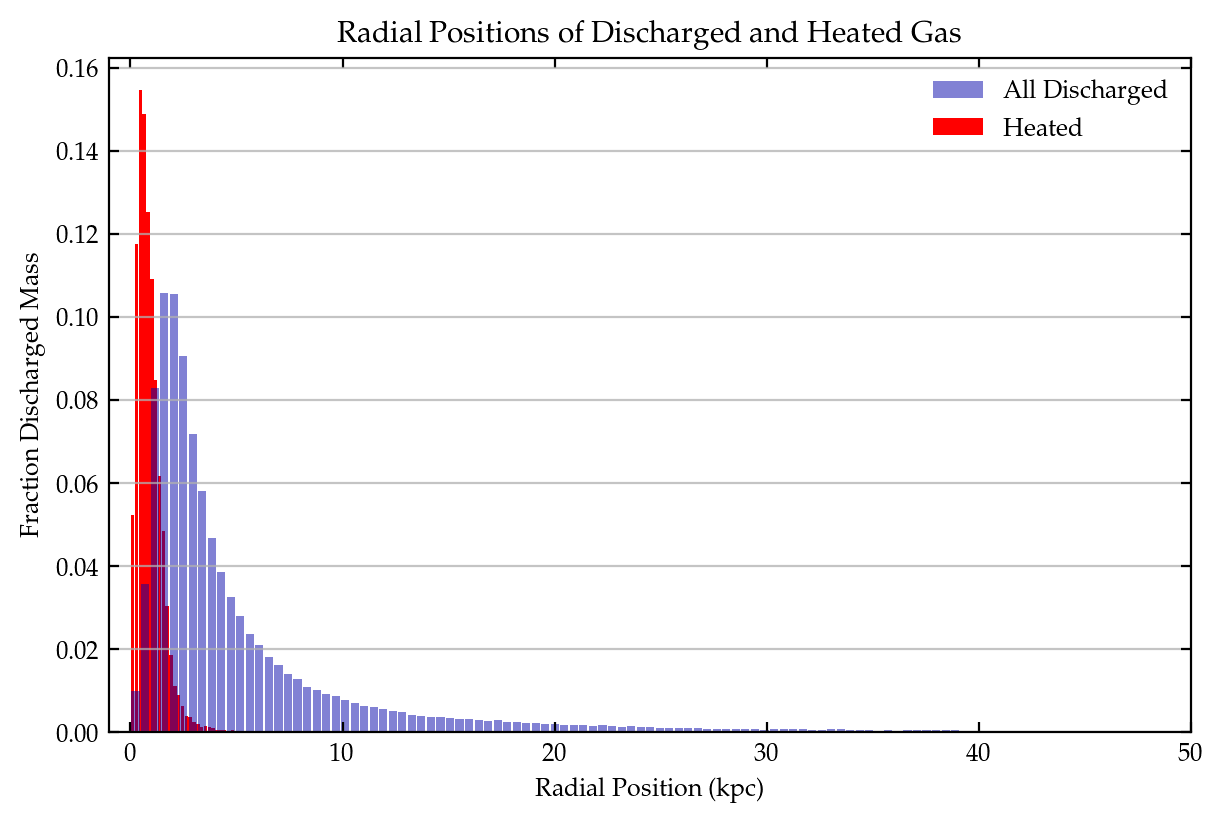

In [20]:
# Velocity histograms for all gas, and heated gas.
bins = 300

plt.figure()
plt.hist(all_radpos, bins=bins, weights=discharged.weight, color='#0504aa', alpha=0.5, rwidth=0.85,\
         label='All Discharged', zorder=-1)

plt.hist(hot_radpos, bins=bins+50, weights=heated.weight, color='red', alpha=1, rwidth=0.90,\
         label='Heated', zorder=-1000)


plt.grid(axis='y', alpha=0.75)
plt.xlabel('Radial Position (kpc)')
plt.ylabel('Fraction Discharged Mass')
plt.title('Radial Positions of Discharged and Heated Gas')

# leg1 = plt.legend(title='Gas', loc='upper left')
# leg1._legend_box.align = 'right'
# legend(loc=(0.26,0.74))

plt.xlim(-1,50)
#plt.ylim(0,0.085)

plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=10)

plt.legend(loc='upper right')
plt.show()

# clean upper 1-axis limit:
#maxfreq= n.max()
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


# bins = 40

# plt.hist(ejected_pos_norm, bins=bins, alpha=0.7, weights=ejected.weight.T, histtype='bar', ec='black')
# plt.hist(hot_pos_norm, bins=bins, alpha=1, weights=hot_weight, histtype='bar', ec='black')


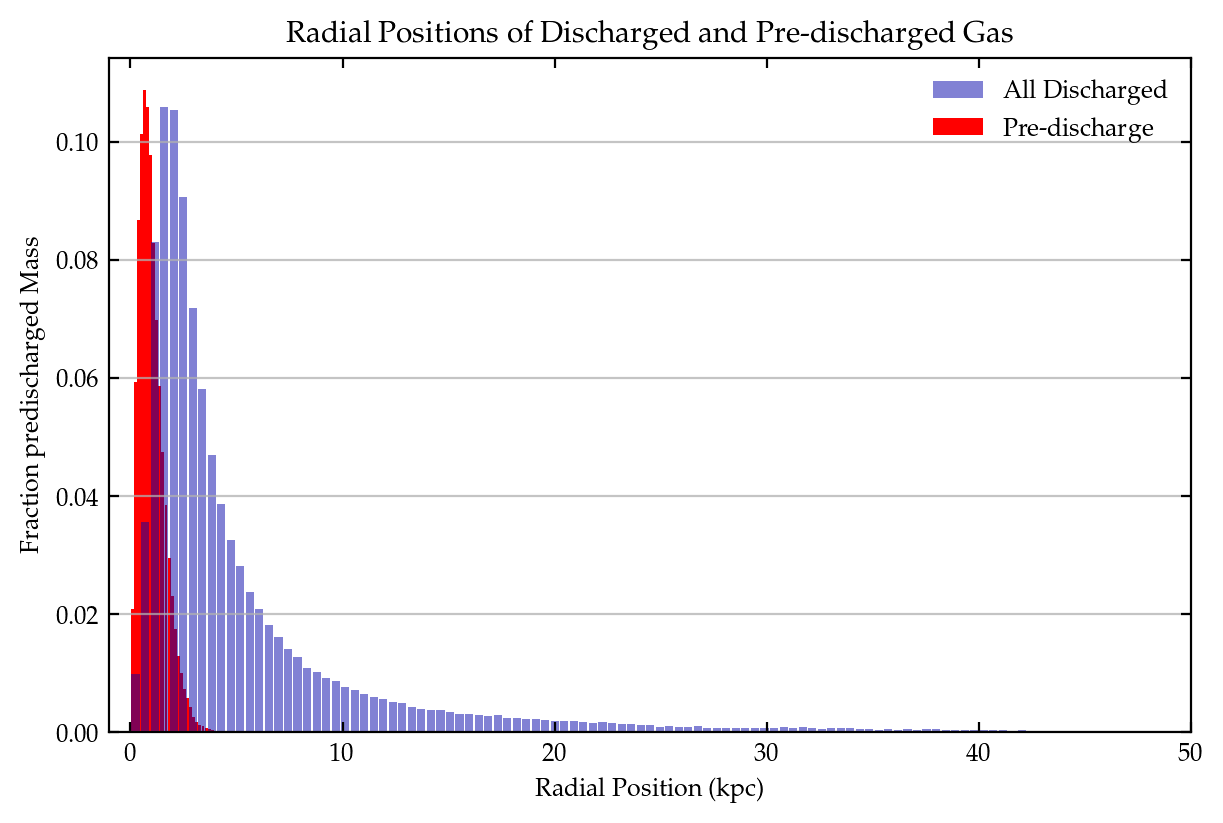

In [21]:
# Velocity histograms for all gas, and heated gas.
bins = 300

plt.figure()
plt.hist(all_radpos, bins=bins, weights=discharged.weight, color='#0504aa', alpha=0.5, rwidth=0.85,\
         label='All Discharged', zorder=-1)
plt.hist(pre_radpos, bins=bins-200, weights=predischarged.weight, color='red', alpha=1, rwidth=0.95,\
         label='Pre-discharge', zorder=-1000)


plt.grid(axis='y', alpha=0.75)
plt.xlabel('Radial Position (kpc)')
plt.ylabel('Fraction predischarged Mass')
plt.title('Radial Positions of Discharged and Pre-discharged Gas')

# leg1 = plt.legend(title='Gas', loc='upper left')
# leg1._legend_box.align = 'right'
# legend(loc=(0.26,0.74))

plt.xlim(-1,50)
#plt.ylim(0,0.085)

plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=10)

plt.legend(loc='upper right')
plt.show()

# clean upper 1-axis limit:
#maxfreq= n.max()
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


# bins = 40

# plt.hist(ejected_pos_norm, bins=bins, alpha=0.7, weights=ejected.weight.T, histtype='bar', ec='black')
# plt.hist(hot_pos_norm, bins=bins, alpha=1, weights=hot_weight, histtype='bar', ec='black')


We plot the histograms as cleaner line plots below to better-observe the trends in positions for the different sets of data.

Further, in these plots, we also include a horizontal dashed line representing the radial position of the 'radial center of mass,' or 'COM,' for each data set.

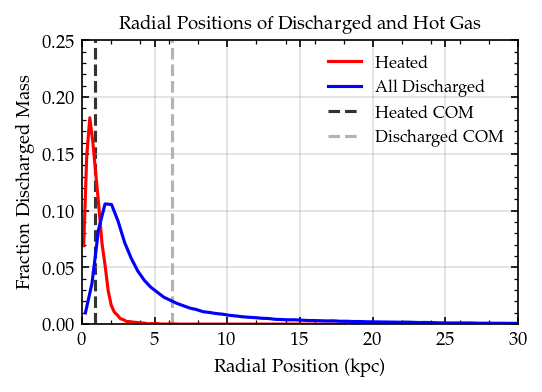

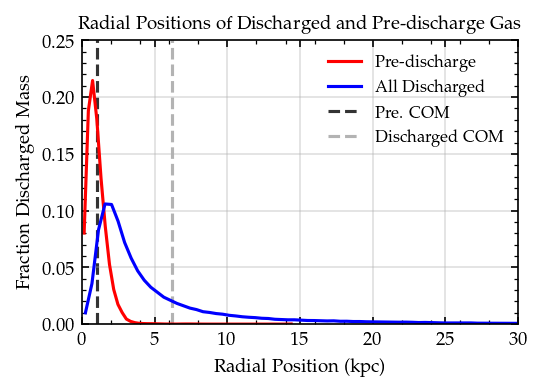

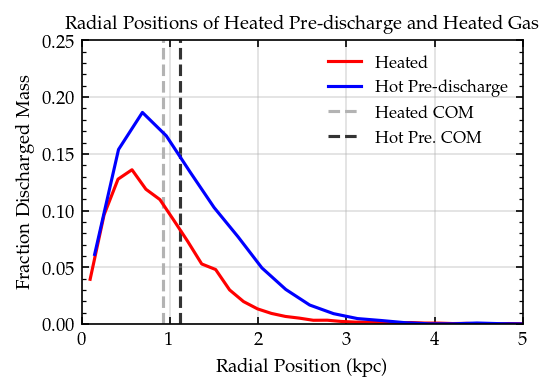

In [22]:
##### plotting discharged vs. heated gas #####
bins = 300
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# applying conditional on distances of gas from center of satellite; collecting frequency and bin information for plot.
y1, x = np.histogram(hot_radpos, bins=bins, weights=heated.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Heated', c='r')

y1, x = np.histogram(all_radpos, bins=bins, weights=discharged.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='All Discharged', c='b')

com1 = hot_radpos.mean()
com2 = all_radpos.mean()
ax.plot([com1,com1],[0,0.3],linestyle='--',color='0.2',zorder=-1, label='Heated COM')
ax.plot([com2,com2],[0,0.3],linestyle='--',color='0.7',zorder=-1, label='Discharged COM')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Positions of Discharged and Hot Gas', fontsize='medium')
ax.set_xlabel(r'Radial Position (kpc)')
ax.set_ylabel('Fraction Discharged Mass')
ax.set_xlim(0,30)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

# ticks = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y*1))
# ax.yaxis.set_major_formatter(ticks)

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')




##### plotting discharged vs. pre-discharged gas #####
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# applying conditional on distances of gas from center of satellite; collecting frequency and bin information for plot.
y1, x = np.histogram(pre_radpos, bins=50, weights=predischarged.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharge', c='r')

y1, x = np.histogram(all_radpos, bins=300, weights=discharged.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='All Discharged', c='b')

com1 = pre_radpos.mean()
com2 = all_radpos.mean()
ax.plot([com1,com1],[0,0.3],linestyle='--',color='0.2',zorder=-1, label='Pre. COM')
ax.plot([com2,com2],[0,0.3],linestyle='--',color='0.7',zorder=-1, label='Discharged COM')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Positions of Discharged and Pre-discharge Gas', fontsize='medium')
ax.set_xlabel(r'Radial Position (kpc)')
ax.set_ylabel('Fraction Discharged Mass')
ax.set_xlim(0,30)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')




##### plotting pre-discharge heated vs. heated gas #####
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# applying conditional on distances of gas from center of satellite; collecting frequency and bin information for plot.
y1, x = np.histogram(hot_radpos, bins=400, weights=heated.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Heated', c='r')

y1, x = np.histogram(hot_pre_radpos, bins=30, weights=hot_predischarged.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Hot Pre-discharge', c='b')


# plot mean position of mass.
com1 = hot_radpos.mean()
com2 = hot_pre_radpos.mean()
ax.plot([com1,com1],[0,0.3],linestyle='--',color='0.7',zorder=-1, label='Heated COM')
ax.plot([com2,com2],[0,0.3],linestyle='--',color='0.2',zorder=-1, label='Hot Pre. COM')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Positions of Heated Pre-discharge and Heated Gas', fontsize='medium')
ax.set_xlabel(r'Radial Position (kpc)')
ax.set_ylabel('Fraction Discharged Mass')
ax.set_xlim(0,5)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')
plt.show()

In [23]:
# finding mean positions of mass.
pre_com = pre_radpos.mean()
hot_pre_com = hot_pre_radpos.mean()
all_com = all_radpos.mean()
hot_com = hot_radpos.mean()

# computing difference in COMs for the above three graphs in order.
print(all_com-hot_com), print(all_com-pre_com), print(hot_com-hot_pre_com);

5.298987271857427
5.193728213349389
-0.18605185391854706


In these above three plots, it is easy to mistake the that the distributions of the different gas selections are nearly identical since all appear to peak near 0 kpc. However, when we also plot indicators locating the averaged radial position (which is here termed the 'radial center of mass' or COM because we analyse a percentage distribution of mass), it becomes clear that there are noteworthy differences in how far each chosen set of gas is from the satellite centers.

In the cases above, it turns out that the radial centers of mass differ as follows:

- The total of discharged gas is ejected $\sim 11.34 \ kpc$ farther than SNe-discharged gas on its own;

- The total of discharged gas is ejected $\sim 14.07 \ kpc$ out from its original location in the satellite disks;

- The SNe-discharged gas moves $\sim 3.06 \ kpc$ out from its original position in the satellite disks (which is not far --- likely just beyond the edge of the disk into the halo).



### Comparing Radial Velocities <a class="anchor" id="velocities"></a>

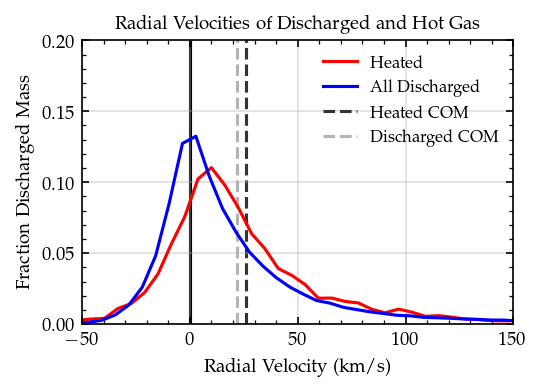

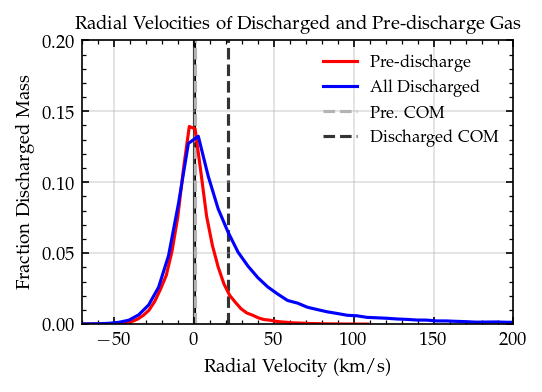

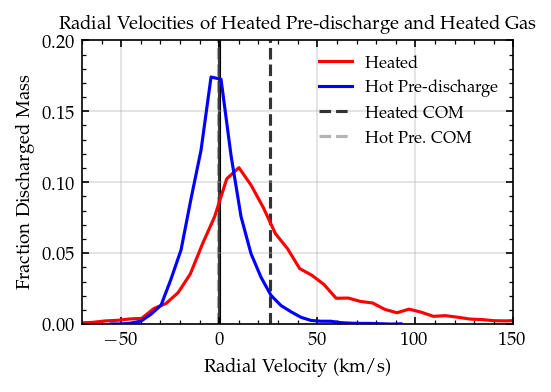

In [24]:
##### plotting discharged vs. heated gas #####
bins = 100
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# applying conditional on distances of gas from center of satellite; collecting frequency and bin information for plot.
y1, x = np.histogram(hot_radvel, bins=bins, weights=heated.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Heated', c='r')

y1, x = np.histogram(all_radvel, bins=bins, weights=discharged.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='All Discharged', c='b')


# plot mean position of mass.
com1 = hot_radvel.mean()
com2 = all_radvel.mean()
ax.plot([com1,com1],[0,0.3],linestyle='--',color='0.2',zorder=-1, label='Heated COM')
ax.plot([com2,com2],[0,0.3],linestyle='--',color='0.7',zorder=-1, label='Discharged COM')

# plot horizontal line for zero velocity.
plotrange = [0,0.33]
ax.plot([0,0],[0,0.3],linestyle='solid',color='black',zorder=-1)


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Velocities of Discharged and Hot Gas', fontsize='medium')
ax.set_xlabel(r'Radial Velocity (km/s)')
ax.set_ylabel('Fraction Discharged Mass')
ax.set_xlim(-50,150)
ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')




##### plotting discharged vs. pre-discharged gas #####
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# applying conditional on distances of gas from center of satellite; collecting frequency and bin information for plot.
y1, x = np.histogram(pre_radvel, bins=50, weights=predischarged.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharge', c='r')

y1, x = np.histogram(all_radvel, bins=100, weights=discharged.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='All Discharged', c='b')


# plot mean position of mass.
com1 = pre_radvel.mean()
com2 = all_radvel.mean()
ax.plot([com1,com1],[0,0.3],linestyle='--',color='0.7',zorder=-1, label='Pre. COM')
ax.plot([com2,com2],[0,0.3],linestyle='--',color='0.2',zorder=-1, label='Discharged COM')

# plot horizontal line for zero velocity.
plotrange = [0,0.33]
ax.plot([0,0],[0,0.3],linestyle='solid',color='black',zorder=-10000)

# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Velocities of Discharged and Pre-discharge Gas', fontsize='medium')
ax.set_xlabel(r'Radial Velocity (km/s)')
ax.set_ylabel('Fraction Discharged Mass')
ax.set_xlim(-70,200)
ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')




##### plotting pre-discharge heated vs. heated gas #####
bins = 100
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# applying conditional on distances of gas from center of satellite; collecting frequency and bin information for plot.
y1, x = np.histogram(hot_radvel, bins=100, weights=heated.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Heated', c='r')

y1, x = np.histogram(hot_pre_radvel, bins=30, weights=hot_predischarged.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Hot Pre-discharge', c='b')


# plot mean position of mass.
com1 = hot_radvel.mean()
com2 = hot_pre_radvel.mean()
ax.plot([com1,com1],[0,0.3],linestyle='--',color='0.2',zorder=-1, label='Heated COM')
ax.plot([com2,com2],[0,0.3],linestyle='--',color='0.7',zorder=-1, label='Hot Pre. COM')

# plot horizontal line for zero velocity.
plotrange = [0,0.33]
ax.plot([0,0],[0,0.3],linestyle='solid',color='black',zorder=-1)


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Velocities of Heated Pre-discharge and Heated Gas', fontsize='medium')
ax.set_xlabel(r'Radial Velocity (km/s)')
ax.set_ylabel('Fraction Discharged Mass')
ax.set_xlim(-70,150)
ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')
plt.show()

The radial centers of mass are again included to better detail the velocity at which the bulk of each gas group is traveling.

All particles are moving out/into the the center of the satellites nearly uniformly, with slight bias towards exiting, as we should expect.

The second plot is particcularly telling of the validity in data collection --- that is, the bulk of gas, before being discharged, has a radial velocity of 0 $km/s$ relative to the center of the satellite galaxies.

In [6]:
discharged.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'r_rel_host',
       'r_rel_host_per_Rvir', 'x_rel_host', 'y_rel_host', 'z_rel_host',
       'hostRvir', 'vx_rel_host', 'vy_rel_host', 'vz_rel_host', 'v_rel_host',
       'sat_Xc', 'sat_Yc', 'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc',
       'host_Yc', 'host_Zc', 'host_vx', 'host_vy', 'host_vz', 'sat_Mstar',
       'sat_Mgas', 'host_Mstar', 'host_Mgas', 'sat_r_half', 'sat_r_gas',
       'host_r_half', 'host_r_gas', 'in_sat', 'in_host', 'in_other_sat',
       'in_IGM', 'dt', 'r_gal', 'host_r_gal', 'sat_disk', 'sat_halo',
       'host_disk', 'host_halo', 'other_sat', 'IGM', 'angle', 'key'],
      dtype='object')

## Fractional SNe-heated ejecta per $r/R_{vir}$ <a class="anchor" id="fractional"></a>

____
____

In this section, we commit to determining the fraction of discharged gas that is SNe-heated at different fractional distances $r/R_{vir}$. In particular, we use a key '$r_Rvir$ for each gas set such that, for every gas particle in these sets, we compute the fraction $r/R_{vir}$, where $r$ is the radial distance of the particle from its respective satellite galaxy and $R_{vir}$ is the virial radius of said satellite. Then for each value $r/R_{vir}$, the fraction of SNe-heated gas out of the total is computed.

We also perform such analysis to determine the fraction of ram pressure-stripped gas to the total of discharged gas at each $r/R_{vir}$.This is then used to gauge whether SNe feedback may be engaging on its own, or if it is also acting alongside ram pressure stripping. 

### Fraction SNe-heated per $r/R_{vir}$ <a class="anchor" id="fractionsne"></a>




### Fraction Ram Pressure-stripped per $r/R_{vir}$ <a class="anchor" id="fractionram"></a>



## Accretion of Discharged Gas <a class="anchor" id="accretion"></a>

Answering the question of what fraction of discharged gas returns to its respective satellite galaxy's disk after expulsion. Furthermore, however, we determine what fraction of sne heated gas indeed returns to the disk.

Of course, our study here hinges on many dependencies: For one, results here depend entirely on how we count gas particle accretion. In the first stage of the analysis here, we simply look at the timestep* after a particle has been discharaged; if it has returned to its satellite's disk in the timestep after discharge, then we count it as being accreted. 

Analysis to be performed later on will require looking at all timesteps (or some yet to be defined 'sufficient number') to determine if the particle is ever accreted, since the original approach ignores the potential for accretion more than one timestep after discharge.

--

*Note that each step in time is defined to be 1 Gigayear.


## Code Testing <a class="anchor" id="proving"></a>

Testing out different data types and computations.